# Time-Series Forecasting on the S&P 500
We are working as a traders on the S&P 500 funds desk. We have been tasked with building a model to better forecast how this index will move based on its behaviour over the past several years. The better our forecast perform the more effectively and lucratively our desk will be able to trade this futures.

## Introduction
The dataset we will be working with is from a yahoo finance via [kaggle](https://www.kaggle.com/datasets/arashnic/time-series-forecasting-with-yahoo-stock-price) and it contains S&P 500 index prices from 2015 through 2020.

Before we get into the data , let's set random values to improve the reproducibility of the model we will build later.

In [1]:
# seed code

import numpy as np
import random
import tensorflow as tf

np.random.seed(4)
random.seed(4)
tf.random.set_seed(4)

 ## Data Wrangling and Exploration
 First, we will load the data and inspect it to determine the steps that will be required for cleaning and preprocessing.

In [2]:
# Data importation

import pandas as pd

stock_data = pd.read_csv("yahoo_stock.csv")
stock_data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [3]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


There are no missing values in the data

The data contains seven columns: `Date`, `High`,`Low`,`Open`,`Close`,`Volume`, and `Adj Close`.

The `Date` column will be use to set the index of the data frame. This is essential in time-series forecasting.

It is possible to use any of the dataset column for forecasting but it's best to use **`Adj Close`** as it has already accounted for any discrete jumps in the index due to stocks paying out [dividends](https://www.investopedia.com/articles/investing/091015/how-dividends-affect-stock-prices.asp).
Based on this decission, we modify th DataFrame to drop the other columns.

In [4]:
# select relevant columns, sort data and set index

stock_data = stock_data[["Date", "Adj Close"]]
stock_data = stock_data.sort_values(by="Date")
stock_data = stock_data.set_index("Date")

# Inspect the data
stock_data.head()

,Adj Close
Date,
2015-11-23,2086.590088
2015-11-24,2089.139893
2015-11-25,2088.870117
2015-11-26,2088.870117
2015-11-27,2090.110107


<Axes: >

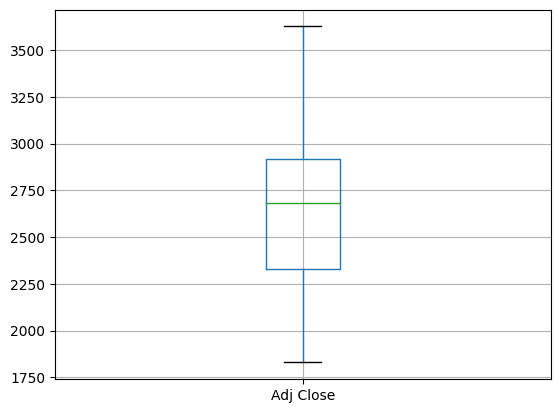

In [5]:
# visualizing outliers in the data
stock_data.boxplot(column = ["Adj Close"])

In [6]:
print(F"Skew value: {stock_data.skew()}")

Skew value: Adj Close    0.081869
dtype: float64


The boxplot and the low skew value of `Adj Close` shows that there's no outliers to be concerned about.

Text(0, 0.5, 'Adjusted Close')

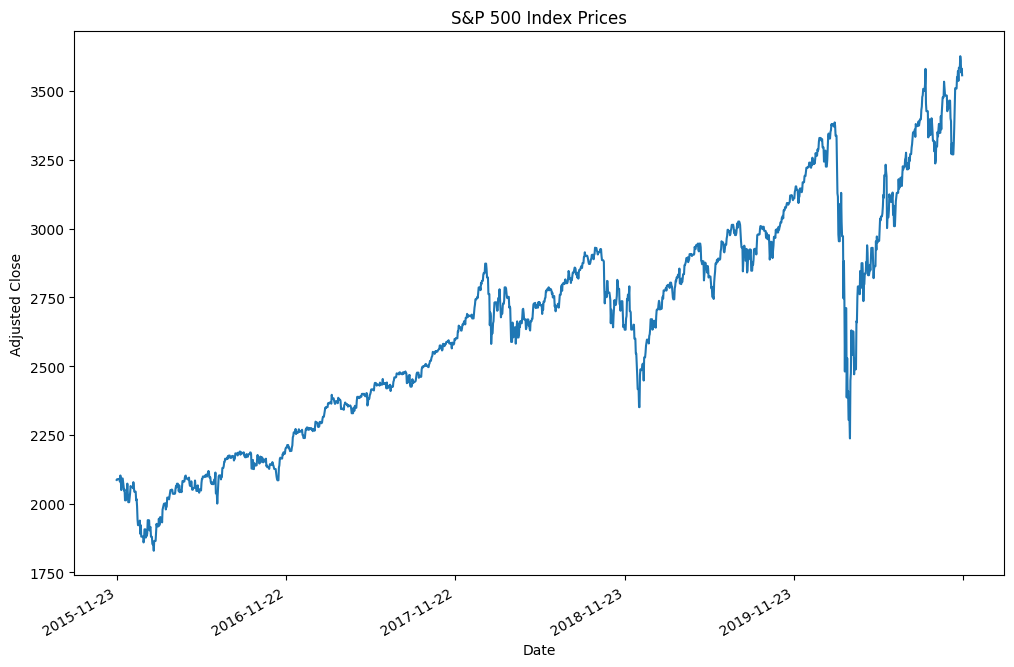

In [7]:
# stock_data visualization

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# plot the data
plt.figure(figsize=(12, 8))
plt.plot(stock_data)

# Add title and axis labels
plt.title("S&P 500 Index Prices")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel("Adjusted Close")

We can see that the data have data from about five years to work with. There are no gaps and there are some visibe spikes and dips.

Clearly there is a pattern here and we want to build a model that can predict that patterns. Before that, we need to preprocess the data and train an RNN model.

## Data Preprocessing
We need to prepare our clean data for modelling. This preparation reqiures the following four steps;
+ Spliting data into training, validation and test sets
+ Scale data to be betwwen 0 and 1
+ Create time windows for each dataset
+ Reshape the data into numpy arrays.

### Splitting the data

In [8]:
# splitting the data to 3 dataset: 60% training, 20% validation and 20% test set.

train_size = int(len(stock_data) * 0.6)
val_size = int(len(stock_data) * 0.2)
test_size = len(stock_data) - train_size - val_size

train_df = stock_data[:train_size]
val_df = stock_data[train_size:train_size + val_size]
test_df = stock_data[train_size + val_size:]

print(f"Train dataset size: {train_df.shape}")
print(f"Validation dataset size: {val_df.shape}")
print(f"Test dataset size: {test_df.shape}")


Train dataset size: (1095, 1)
Validation dataset size: (365, 1)
Test dataset size: (365, 1)


### Scaling the data

In [9]:
from sklearn.preprocessing import MinMaxScaler

# fit scaler
scaler = MinMaxScaler()
scaler.fit(train_df)

# scale data
train = pd.DataFrame(scaler.transform(train_df), columns= ["Adj Close"], index=train_df.index)
val = pd.DataFrame(scaler.transform(val_df), columns= ["Adj Close"], index=val_df.index)
test = pd.DataFrame(scaler.transform(test_df), columns= ["Adj Close"], index=test_df.index)



### Time Window for each dataset

In [10]:
# A Function to construct windowed datasets

def create_dataset(dataset, window_size=1):
  data_x, data_y = [], []
  for i in range(len(dataset) - window_size - 1):
    window = dataset.iloc[i : (i + window_size), 0]
    target = dataset.iloc[i + window_size, 0]
    data_x.append(window)
    data_y.append(target)
  return np.array(data_x), np.array(data_y)

# set the desired  window size
window_size = 10

# create the datasets
X_train, y_train = create_dataset(train, window_size)
X_val, y_val = create_dataset(val, window_size)
X_test, y_test = create_dataset(test, window_size)



### Reshaping into NumPy arrays

In [11]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Build and Train a Basic RNN Model
We have thoroughly prepare our data for modelling and now we need to build a TensorFlow model to make forcasts.

Let's start with a `SimpleRNN` model.

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

# Build the model
model = tf.keras.Sequential()
model.add(layers.SimpleRNN(10, input_shape=(1, window_size), activation = "relu"))
model.add(layers.Dense(10, activation = "relu"))
model.add(layers.Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 331 (1.29 KB)

 Trainable params: 331 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

We've built the model. let's train it on our training dataset and evaluate it performance using the validation dataset.

We are not using the `test` dataset yet because we want to have a clean, untouched testing dataset for our final model evaluation.

In [13]:
from sklearn.metrics import r2_score

# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_val)
print(f"R2 Score: {r2_score(y_val, y_pred)}")


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4302
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R2 Score: -29.392504406640594


Opps, the R-Squared is not looking good. Let's see if we can improve upon our model

## Build and Train an LSTM Model

Let's repeat the above steps for an LSTM model and see if we can improve performance

In [14]:
# Build the model
model = tf.keras.Sequential()
model.add(layers.LSTM(10, input_shape=(1, window_size), activation = "relu"))
model.add(layers.Dense(10, activation = "relu"))
model.add(layers.Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_val)
print(f"R2 Score: {r2_score(y_val, y_pred)}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10)                  │             840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 961 (3.75 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2913
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R2 Score: -23.4283904643955


That didn't improved liked we hoped for. For now let's keep the LSTM in place untill we are ready to fully optimize the model.

## Add a Convolutional Layer

In [15]:
# Build the model
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, 1, input_shape=(1, window_size), activation = "relu"))
model.add(layers.MaxPooling1D(1))
model.add(layers.LSTM(10, activation = "relu"))
model.add(layers.Dense(10, activation = "relu"))
model.add(layers.Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_val)
print(f"R2 Score: {r2_score(y_val, y_pred)}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1, 64)               │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 10)                  │           3,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,825 (14.94 KB)

 Trainable params: 3,825 (14.94 KB)

 Non-trainable params: 0 (0.00 B)

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1444
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R2 Score: -0.4885161697615765


These are still bad results. Let's go further and try modifying other model parameters to fully optimize the model.

In [16]:
# New window size
window_size = 25

# create the datasets
X_train, y_train = create_dataset(train, window_size)
X_val, y_val = create_dataset(val, window_size)
X_test, y_test = create_dataset(test, window_size)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build the model
model = tf.keras.Sequential()
model.add(layers.Conv1D(128, 1, input_shape=(1, window_size), activation = "relu"))
model.add(layers.MaxPooling1D(1))
model.add(layers.LSTM(64, activation = "relu"))
model.add(layers.Dense(32, activation = "relu"))
model.add(layers.Dense(16, activation = "relu"))
model.add(layers.Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

# Train the model
model.fit(X_train, y_train, epochs = 40, verbose= False)

# Make predictions and evaluate
y_pred = model.predict(X_val)
print(f"R2 Score on validation set: {r2_score(y_val, y_pred)}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 1, 128)              │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,361 (216.25 KB)

 Trainable params: 55,361 (216.25 KB)

 Non-trainable params: 0 (0.00 B)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
R2 Score on validation set: 0.9394677075403746


We achieved an `R-squared` value of **0.93** on the validation set, which is impersive. As a final performance check. we should now compute and visualize the performance on the test set.

## Evaluate Model Performance
Finally! we are satisfied with our model performance on validation set. Let's use the model to make prediction on the test set and compute our final R- squared. While we are at it , since we'll need them for plotting, let's make prediction on all the three sets: traing, validation and testing.

In [17]:
# Make Predictions on all three datasets

train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

print(f"R2 Score on training set: {r2_score(y_train, train_pred)}")
print(f"R2 Score on validation set: {r2_score(y_val, val_pred)}")
print(f"R2 Score on test set: {r2_score(y_test, test_pred)}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R2 Score on training set: 0.9945412443389152
R2 Score on validation set: 0.9394677075403746
R2 Score on test set: 0.9320562934731487


Our Model Performance is Good. Let's visualize this performance.

First we need to undo the scaling and windowing preprocessing we've done.

In [18]:
# Un-scale the prediction
train_pred = scaler.inverse_transform(train_pred)
val_pred = scaler.inverse_transform(val_pred)
test_pred = scaler.inverse_transform(test_pred)

# Un-window the training predictions
plot_train_pred = np.empty((len(stock_data), 1))
plot_train_pred[:] = np.nan
plot_train_pred[window_size:len(train_pred) + window_size, :] = train_pred

# Un-window the validation predictions
plot_val_pred = np.empty((len(stock_data), 1))
plot_val_pred[:] = np.nan
plot_val_pred[len(train_pred) + (window_size * 2) + 1 : len(train_pred) + len(val_pred) + (window_size * 2) + 1, :] = val_pred

# Un-window the test predictions
plot_test_pred = np.empty((len(stock_data), 1))
plot_test_pred[:] = np.nan
plot_test_pred[len(train_pred) + len(val_pred) + (window_size *3) + 2 : len(stock_data) - 1, :] = test_pred

Finally, let's plot the un-scaled and un-windowed data on the original `stock_data` dataset.

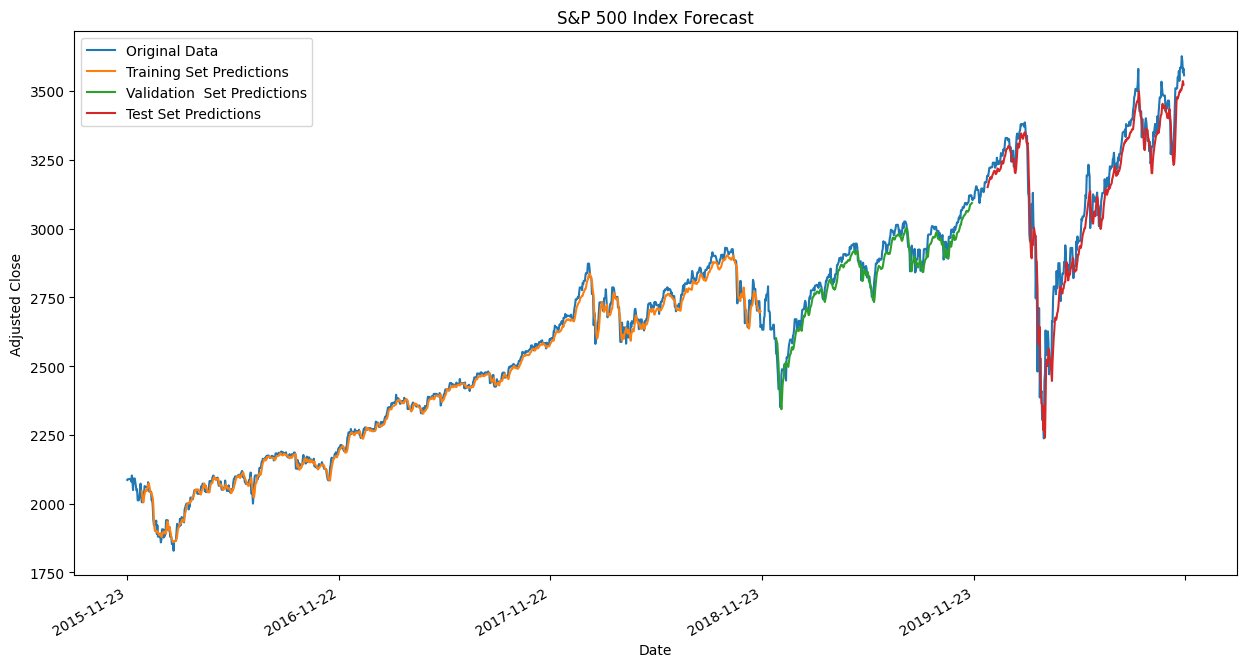

In [19]:
# plot the original data
plt.figure(figsize=(15, 8))
plt.plot(stock_data, label = "Original Data")

# plot the predictions
plt.plot(plot_train_pred, label = "Training Set Predictions")
plt.plot(plot_val_pred, label = "Validation  Set Predictions")
plt.plot(plot_test_pred, label = "Test Set Predictions")

# Add title, axis, labels and a legend
plt.title("S&P 500 Index Forecast")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel("Adjusted Close")
plt.legend()
plt.show()

## Conclusion
The visualization looks as great as the R-squared value suggested it might.

This project is only meant to be fun and educational!
If successfully predicting the market trends was "this easy", everyone would do it.